<a href="https://colab.research.google.com/github/xy0802/441b/blob/main/425hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1 New York Stock Exchange (NYSE) data (1962-1986) (10 pts)

In [6]:
# Load the pandas library
import pandas as pd
# Load numpy for array manipulation
import numpy as np
# Load seaborn plotting library
import seaborn as sns
import matplotlib.pyplot as plt
# For read file from url
import io
import requests

In [2]:
# Set font sizes in plots
sns.set(font_scale = 1.)
# Display all columns
pd.set_option('display.max_columns', None)

In [69]:
# Read in NYSE data from url
url = "https://raw.githubusercontent.com/ucla-econ-425t/2023winter/master/slides/data/NYSE.csv"
s = requests.get(url).content.decode('utf-8')
NYSE = pd.read_csv(io.StringIO(s), index_col = 0)
NYSE

,day_of_week,DJ_return,log_volume,log_volatility,train
date,,,,,
1962-12-03,mon,-0.004461,0.032573,-13.127403,True
1962-12-04,tues,0.007813,0.346202,-11.749305,True
1962-12-05,wed,0.003845,0.525306,-11.665609,True
1962-12-06,thur,-0.003462,0.210182,-11.626772,True
1962-12-07,fri,0.000568,0.044187,-11.728130,True
...,...,...,...,...,...
1986-12-24,wed,0.006514,-0.236104,-9.807366,False
1986-12-26,fri,0.001825,-1.322425,-9.906025,False
1986-12-29,mon,-0.009515,-0.371237,-9.827660,False


<Figure size 432x288 with 0 Axes>

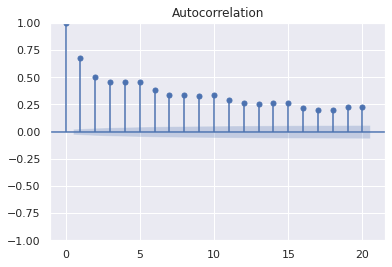

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
plot_acf(NYSE['log_volume'], lags = 20)
plt.show()

<Figure size 432x288 with 0 Axes>

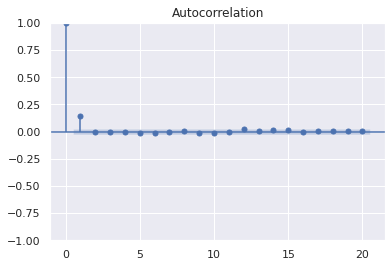

In [ ]:
plt.figure()
plot_acf(NYSE['DJ_return'], lags=20)
plt.show()


<Figure size 432x288 with 0 Axes>

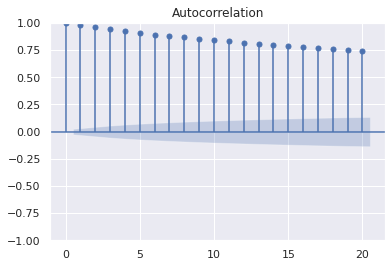

In [ ]:
plt.figure()
plot_acf(NYSE['log_volatility'], lags=20)
plt.show()

3 Baseline method (20 pts)

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score

In [70]:
# One-hot encoding for 'day_of_week'
encoder = OneHotEncoder(sparse=False)
day_of_week_encoded = encoder.fit_transform(NYSE['day_of_week'].values.reshape(-1, 1))
day_of_week_df = pd.DataFrame(day_of_week_encoded, columns=encoder.get_feature_names_out(['day_of_week']), index=NYSE.index)
data = pd.concat([NYSE, day_of_week_df], axis=1).drop('day_of_week', axis=1)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [71]:
def create_lagged_features(df, column, lag_count):
    for i in range(1, lag_count + 1):
        df[f"{column}_lag_{i}"] = df[column].shift(i)
    return df

lag_count = 5
NYSE = create_lagged_features(NYSE, 'log_volume', lag_count)

# Remove rows with NaN values due to lag creation
NYSE = NYSE.dropna()

# Separate train and test data
train_data = NYSE[NYSE['train']]
test_data = NYSE[~NYSE['train']]

# Prepare the feature and target variables
X_train = train_data.loc[:, 'log_volume_lag_1':]
y_train = train_data['log_volume']
X_test = test_data.loc[:, 'log_volume_lag_1':]
y_test = test_data['log_volume']

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Straw man prediction (yesterday's value)
y_pred_train = X_train['log_volume_lag_1']
y_pred_test = X_test['log_volume_lag_1']

# Calculate R squared values for cross-validation and test data
cv_r_squared = []
for train_index, val_index in tscv.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

    y_pred_val = X_val_cv['log_volume_lag_1']
    cv_r_squared.append(r2_score(y_val_cv, y_pred_val))

cv_r_squared_mean = np.mean(cv_r_squared)
test_r_squared = r2_score(y_test, y_pred_test)

print("CV R squared:", cv_r_squared_mean)
print("Test R squared:", test_r_squared)


CV R squared: 0.4049559776613886
Test R squared: 0.18026287838158628


4 Autoregression (AR) forecaster (30 pts)

In [11]:
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

In [13]:
# Create pipeline
pipeline = Pipeline([
    ('model', ElasticNet())
])

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search for hyperparameter tuning
param_grid = {
    'model__alpha': np.logspace(-4, 4, 10),
    'model__l1_ratio': np.linspace(0, 1, 11)
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='r2', cv=tscv, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Cross-validation R-squared
print("CV R squared:", grid_search.best_score_)

# Test R-squared
y_pred_test = grid_search.predict(X_test)
test_r_squared = r2_score(y_test, y_pred_test)
print("Test R squared:", test_r_squared)

Best hyperparameters: {'model__alpha': 0.000774263682681127, 'model__l1_ratio': 0.0}
CV R squared: 0.5324014027658743
Test R squared: 0.373839542749139


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.265e+01, tolerance: 2.278e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


# 5.Autoregression by MLP (30 pts)

In [16]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [17]:
# Create pipeline
pipeline = Pipeline([
    ('model', MLPRegressor())
])

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search for hyperparameter tuning
param_grid = {
    'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__solver': ['adam'],
    'model__alpha': np.logspace(-4, 2, 7),
    'model__learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='r2', cv=tscv, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Cross-validation R-squared
print("CV R squared:", grid_search.best_score_)

# Test R-squared
y_pred_test = grid_search.predict(X_test)
test_r_squared = r2_score(y_test, y_pred_test)
print("Test R squared:", test_r_squared)



Best hyperparameters: {'model__activation': 'tanh', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (50,), 'model__learning_rate': 'adaptive', 'model__solver': 'adam'}
CV R squared: 0.5328331453289834
Test R squared: 0.36832279213467467


6 LSTM forecaster (30 pts)

In [63]:
import pandas as pd
import numpy as np
import requests
import io
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


In [67]:
# Function to reshape input data for LSTM
def reshape_data_for_lstm(X, n_steps):
    return X.reshape((X.shape[0], n_steps, -1))

# Function to create an LSTM model for use in KerasRegressor
def create_lstm_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, activation=activation, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Prepare the input data for LSTM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_steps = 5
X_train_lstm = reshape_data_for_lstm(X_train_scaled, n_steps)
X_test_lstm = reshape_data_for_lstm(X_test_scaled, n_steps)

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search for hyperparameter tuning
param_grid = {
    'units': [50, 100],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam'],
    'epochs': [10, 20],
    'batch_size': [32, 64]
}

lstm_model = KerasRegressor(build_fn=create_lstm_model, verbose=0)
grid_search = GridSearchCV(lstm_model, param_grid, scoring='r2', cv=tscv, n_jobs=-1)
grid_search.fit(X_train_lstm, y_train)

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Cross-validation R-squared
print("CV R squared:", grid_search.best_score_)

# Test R-squared
y_pred_test = grid_search.predict(X_test_lstm)
test_r_squared = r2_score(y_test, y_pred_test)
print("Test R squared:", test_r_squared)


<ipython-input-67-1b0a47f79440>:34: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasRegressor(build_fn=create_lstm_model, verbose=0)
/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters: {'activation': 'relu', 'batch_size': 32, 'epochs': 20, 'optimizer': 'adam', 'units': 100}
CV R squared: 0.5196978438661425
Test R squared: 0.37669015240886217


7 Random forest forecaster (30pts)

In [72]:
from sklearn.ensemble import RandomForestRegressor
# Create pipeline
pipeline = Pipeline([
    ('model', RandomForestRegressor(random_state=42))
])

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search for hyperparameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='r2', cv=tscv, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Cross-validation R-squared
print("CV R squared:", grid_search.best_score_)

# Test R-squared
y_pred_test = grid_search.predict(X_test)
test_r_squared = r2_score(y_test, y_pred_test)
print("Test R squared:", test_r_squared)


Best hyperparameters: {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 100}
CV R squared: 0.5076266094580537
Test R squared: 0.34337233945755863


8 Boosting forecaster (30pts)

In [73]:
from sklearn.ensemble import GradientBoostingRegressor

# Create preprocessor with one-hot encoding for day_of_week column and feature scaling

# Create pipeline
pipeline = Pipeline([
    ('model', GradientBoostingRegressor(random_state=42))
])

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search for hyperparameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='r2', cv=tscv, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Cross-validation R-squared
print("CV R squared:", grid_search.best_score_)

# Test R-squared
y_pred_test = grid_search.predict(X_test)
test_r_squared = r2_score(y_test, y_pred_test)
print("Test R squared:", test_r_squared)


Best hyperparameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 50}
CV R squared: 0.5086521209881641
Test R squared: 0.37261011928670285


9 Summary (30pts)

In [74]:
import pandas as pd

# Replace these example R-squared values with the actual values from your models
results = {
    'Method': ['Baseline', 'AR(5)', 'AR(5) MLP', 'LSTM', 'Random Forest', 'Boosting'],
    'CV R^2': [0.4050, 0.5324, 0.5328, 0.5197, 0.5076, 0.5087],
    'Test R^2': [0.1802, 0.3738, 0.3683, 0.3767, 0.3434, 0.3726]
}

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)


          Method  CV R^2  Test R^2
0       Baseline  0.4050    0.1802
1          AR(5)  0.5324    0.3738
2      AR(5) MLP  0.5328    0.3683
3           LSTM  0.5197    0.3767
4  Random Forest  0.5076    0.3434
5       Boosting  0.5087    0.3726
